In [246]:
%matplotlib inline
import numpy as np
from ipywidgets import interactive, widgets
from matplotlib import pyplot as plt
from IPython.display import Image
import healpy as hp
import scipy.interpolate
from scipy.optimize import curve_fit

def wrap_around_180(ra_deg):
    ra = np.deg2rad(ra_deg)
    ra[ra > np.pi] -= 2*np.pi
    return ra

# What is Multimessenger Astronomy?

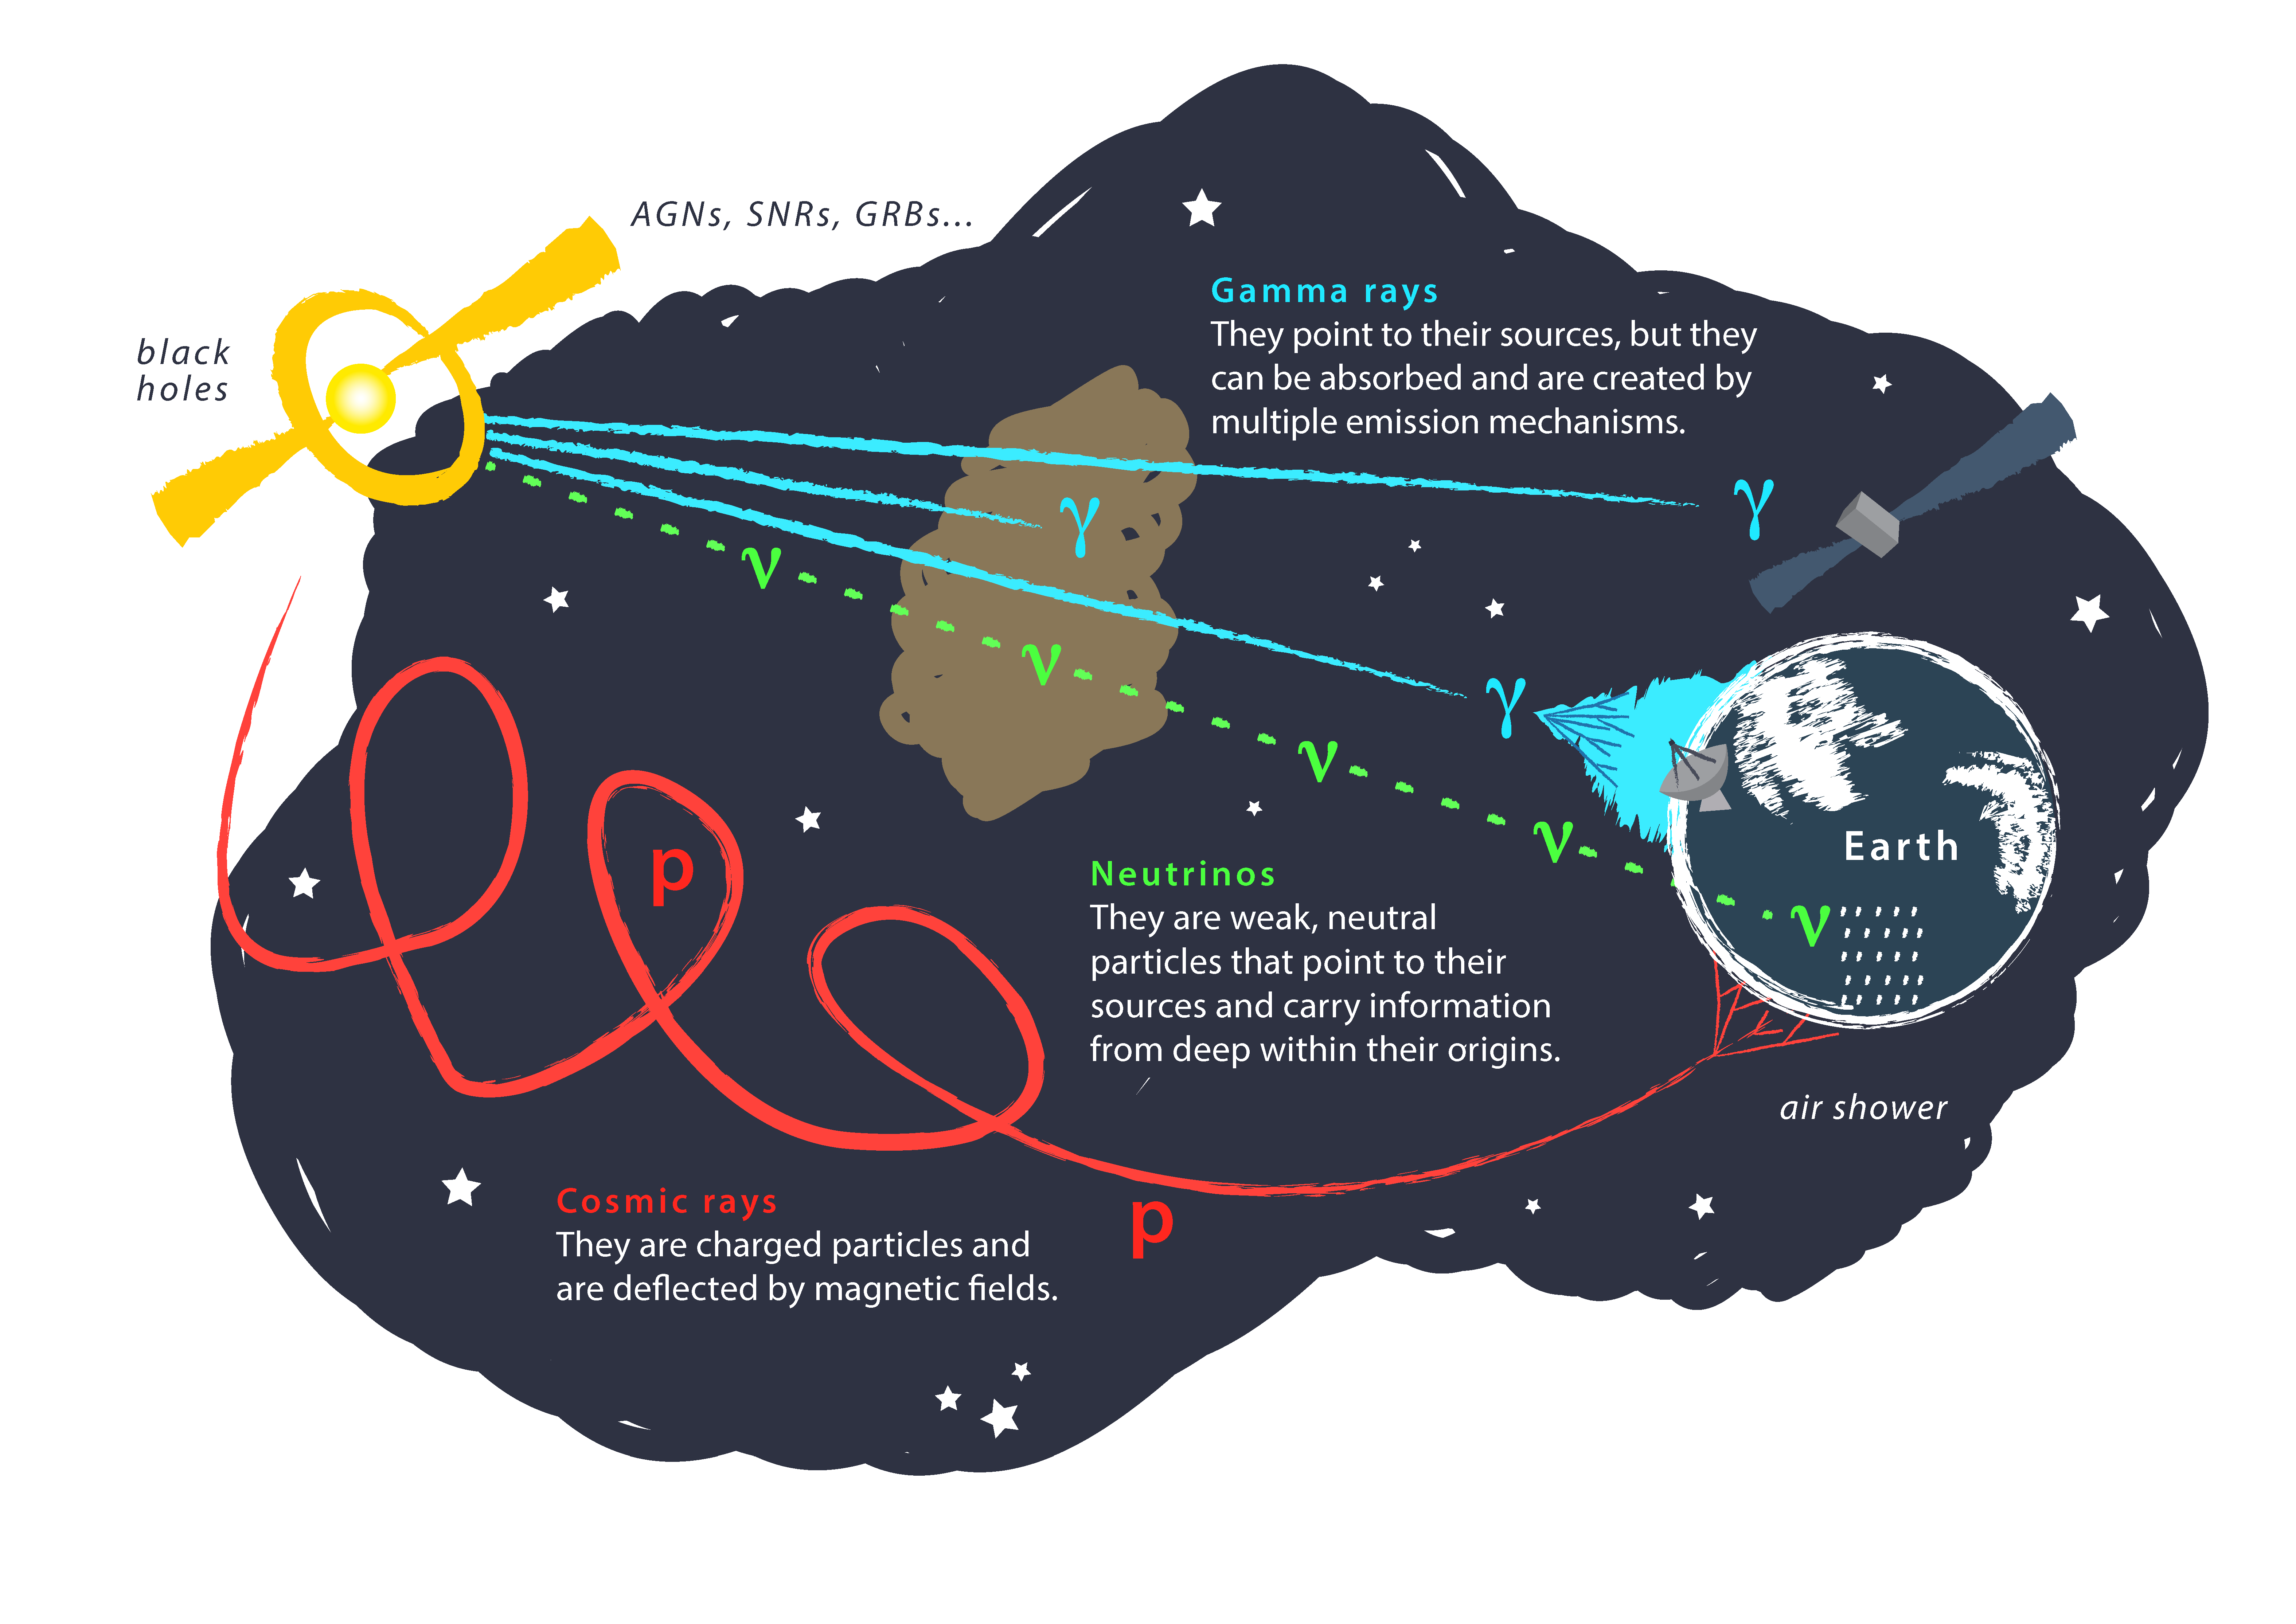

In [247]:
Image("https://icecube.wisc.edu/news/img/news_attachment.file.beacd13cc3892fcc.636f736d69635f6d657373656e676572732e706e67.png",width=800)

# Cosmic Ray data from the Pierre Auger Observatory

This section utilises publically-available data from the Pierre Auger Observatory (PAO), detailing Ultra-High-energy Cosmic Ray (UHECR) events detected by the PAO. The Observatory consists of 1600 surface 1600 water cherenkov detectors, spaced roughly ~1.5km apart. There are 27 complemntary fluorescence detectors, so PAO is a "hybrid detector". The surface tanks gives PAO a huge surface area of ~3000km2, enabling it to observe the rare events from the high-energy tail of the Cosmic Ray spectrum (the "Ankle Region").

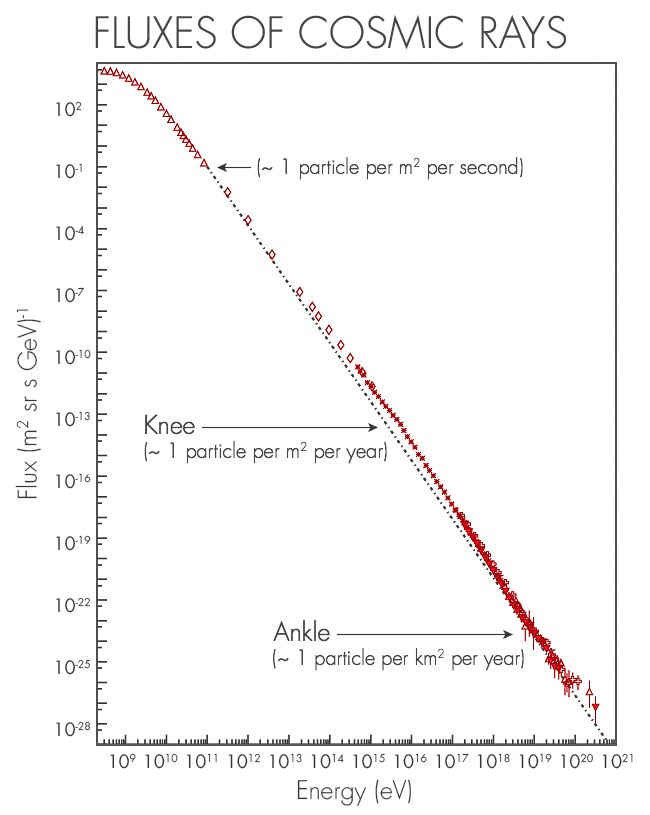

In [248]:
Image('https://d2r55xnwy6nx47.cloudfront.net/uploads/2015/05/SwordyCosmicRaySpectrum_v1.jpg',width=500)

The public data list all events with a reconstructed Energy in the range 4-8 8 EeV (1 EeV = 10^18 eV), and zenith < 80 deg, from Jan 1 2004 up to 31 August 2016.

The columns in the data table are:

year day  dec   RA   azimuth weight (angles in deg)

In [249]:
auger_data = np.loadtxt("auger/events_a8.dat", skiprows=5, dtype=np.float)
print(auger_data)

[[ 2.004e+03  1.000e+00 -1.180e+01  2.089e+02  1.647e+02  1.004e+00]
 [ 2.004e+03  2.000e+00 -7.040e+01  3.660e+01 -1.116e+02  1.003e+00]
 [ 2.004e+03  3.000e+00 -4.780e+01  3.347e+02 -1.438e+02  9.980e-01]
 ...
 [ 2.016e+03  2.440e+02 -2.390e+01  9.920e+01  1.464e+02  9.971e-01]
 [ 2.016e+03  2.440e+02 -4.700e+01  1.225e+02 -1.457e+02  9.990e-01]
 [ 2.016e+03  2.440e+02 -4.520e+01  1.517e+02 -1.391e+02  9.998e-01]]


### Cosmic Ray Arrival Times

We can firstly look at the distribution of Cosmic Ray detections as a function of time. 

In [250]:
arrival_times = auger_data[:,0] + auger_data[:,1]/365.

def arrival_hist(n_bins):
    plt.figure()
    plt.hist(arrival_times, weights=auger_data[:,5], bins=n_bins)
    plt.xlabel("Year")
    plt.ylabel("Detected Cosmic Rays")
    plt.show()
    
interactive(arrival_hist, n_bins=widgets.IntSlider(min=5,max=100,step=5, value=25))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2nigKY=


The Pierre Auger observatory began data-taking while surface tanks were stil being constructed, so the event rate increases with time. With finer binning, periods of downtime for the detector become visible.

### What can the Pierre Auger Observatory see?

The Pierre Auger detector is located in the Southern Hemisphere, at a site in Argentina. Due to the Earth's rotation, the detector sensitivity for different regions of the sky varies with time.

In [251]:
azimuth = auger_data[:,4]

def azimuth_hist(n_bins):
    plt.figure()
    plt.hist(azimuth, bins=n_bins, weights=auger_data[:,5],)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Detected Cosmic Rays")
    plt.show()
    
interactive(azimuth_hist, n_bins=widgets.IntSlider(min=5,max=360,step=5, value=25))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtYXg9MzYwLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXPigKY=


### Where are the events detected?

The following code plots the PAO events on a projected skymap, in equatorial (Earth-based) coordinates. You can clearly see the region in the Northern Sky that PAO cannot observe, due to the observatory's southern location. The colour scale indicates arrival time, with blue events arriving earliest, and red latest. The slider illustrates how the skymap developed over time, as the observatory collected more data.

In [253]:
cm = plt.cm.get_cmap('jet')

def skymap(time):
    mask = arrival_times < time
    fig = plt.figure()
    plt.subplot(211, projection="mollweide")

    sc = plt.scatter(wrap_around_180(auger_data[:,3][mask]), np.deg2rad(auger_data[:,2][mask]),
                cmap=cm, c=arrival_times[mask], vmin=2004.0, vmax=2016.5, s=2)
    
    cbar = plt.colorbar(sc)
    cbar.set_label('Arrival Time')
    
    plt.suptitle("Equitorial Skymap up to " + str(time))
    plt.tight_layout()
    fig.set_size_inches(10, 8)
    plt.show()
    
interactive(skymap, time=widgets.FloatSlider(min=2004., max=2016.5, step=0.5, value=2004.5))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIwMDQuNSwgZGVzY3JpcHRpb249dSd0aW1lJywgbWF4PTIwMTYuNSwgbWluPTIwMDQuMCwgc3RlcD0wLjUpLCBPdXRwdXTigKY=


It is impossible to see from this scatter plot whether the arrival direction of the UHECRs is isotropic, or if there is a structure to the distribution. Instead, we can create a histogram of the data, to see if there are any excesses in the sky. Due to the variable exposure of the PAO to the sky as a function of time, each event has weight assigned to it to account for this effect.

We can create histograms using Healpy, which divides the sky into evenly-sized bins. Healpy enables easy transformation between different coordinate systems. We can mask the regions with declination>45 degrees, since the data contains no events in those areas.

In [254]:
def mollweide_skymap(NSIDE, coords, gauss_radius):
    N_pix = hp.nside2npix(NSIDE)
    
    pix = hp.ang2pix(NSIDE, 0.5*np.pi - np.deg2rad(auger_data[:,2]), -auger_data[:,3])
    bins = np.histogram(pix, weights=auger_data[:,5], bins=np.arange(N_pix +1))

    mask = hp.pix2ang(NSIDE, range(0, N_pix))[0] < 0.25 * np.pi
    masked_map = hp.ma(bins[0])
    masked_map.mask = mask
    masked_map = hp.sphtfunc.smoothing(masked_map, sigma=gauss_radius)
    
    hp.mollview(masked_map, coord=coords, title="UHECR Arrival Direction, with " + str(N_pix) + " pixels")
    
interactive(mollweide_skymap, NSIDE=widgets.IntSlider(min=1, max=50, value=8),coords=widgets.Dropdown(
    options={'Equatorial': "C", 'Ecliptic': "CE", 'Galactic': "CG"},
    value="C", description='Coordinates:'),
            gauss_radius=widgets.FloatSlider(min=0., max=1., step=0.1, value=0.)
)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT04LCBkZXNjcmlwdGlvbj11J05TSURFJywgbWF4PTUwLCBtaW49MSksIERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnQ29vcmRpbmHigKY=


It is apparent that there is a strong clustering of events in the region surrounding the south pole. However, this is unsuprising when you think about the exposure time for each pixel. One day's worth of data will be split between a handful of pixels close to the pole, but many more pixels along the equator. We can correct for this effect, to estimate the detection rate for each pixel per unit time. The exposure time per pixel at any given declination is proportional to 1/Sin(declination). If we weight each pixel by Sin(declination), we recover the detection rate per unit exposure time.

In [256]:
def exposure_corrected_skymap(NSIDE, coords, gauss_radius):
    N_pix = hp.nside2npix(NSIDE)
    dec = 0.5*np.pi - np.deg2rad(auger_data[:,2])
    pix = hp.ang2pix(NSIDE, dec, -auger_data[:,3])
    
    bins = np.histogram(pix, weights=auger_data[:,5]*np.sin(dec), bins=np.arange(N_pix +1))
    
    mask = hp.pix2ang(NSIDE, range(0, N_pix))[0] < 0.25 * np.pi
    masked_map = hp.ma(bins[0])
    masked_map = hp.sphtfunc.smoothing(masked_map, sigma=gauss_radius)
    hp.mollview(masked_map, coord=coords, title="UHECR Detection Rate per unit exposure time, with " + str(N_pix) + " pixels")
    hp.graticule()
    
interactive(exposure_corrected_skymap, NSIDE=widgets.IntSlider(min=1, max=50, value=8),coords=widgets.Dropdown(
    options={'Equatorial': "C", 'Ecliptic': "CE", 'Galactic': "CG"},
    value="C", description='Coordinates:'),
            gauss_radius=widgets.FloatSlider(min=0., max=1., step=0.2, value=0.)
)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT04LCBkZXNjcmlwdGlvbj11J05TSURFJywgbWF4PTUwLCBtaW49MSksIERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnQ29vcmRpbmHigKY=


In this view, we can get a sense of where in the sky the Pierre Auger Detector is most sensitive. It is clear that the highest detection rate is in the Southern Hemisphere, with clear event clustering around the -30deg latitude line. This is, unsurpringly, close to the location of the detector (which lies at -35deg). You can also see this effect by viewing a histogram of event declination.

In [257]:
dec = auger_data[:,2]

def dec_hist(n_bins):
    plt.figure()
    plt.hist(dec, bins=n_bins, weights=auger_data[:,5])
    plt.xlabel("Declination (degrees)")
    plt.ylabel("Detected Cosmic Rays")
    plt.show()
    
interactive(dec_hist, n_bins=widgets.IntSlider(min=5,max=180, step=5, value=25))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtYXg9MTgwLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXPigKY=


In general, it is diffult for the PAO to measure any anisotropy in the declination distribution. The detector acceptance depends heavily on the declination, and the uncertanties on the acceptance would need to be small in comparison to any potential anisotropy. However, it is much easier to search for anisotropy in Right Ascension. For any given declination, the acceptance as a function of RA should be almost uniform. So, if we see a non-uniform distribution, we can say that there is anisotropy in the arrival direction. We can try searching with a simple histogram:

In [258]:
ra = auger_data[:,3]

def ra_hist(n_bins):
    plt.figure()
    plt.hist(ra, bins=n_bins, weights=auger_data[:,5],)
    plt.xlabel("Declination (degrees)")
    plt.ylabel("Detected Cosmic Rays")
    plt.show()
    
interactive(ra_hist, n_bins=widgets.IntSlider(min=5,max=180, step=5, value=25))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtYXg9MTgwLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXPigKY=


We can search for anisotropy by calculating the deviation in each bin from a uniform deviation. The simplest deviation we could see would be a dipole, meaning that the deviations would be sinusoidal. We can assume that each bin has a poissonian count error.

In [259]:
def plot_excess(n_bins):
    baseline = float(len(ra))/float(n_bins)
    bin_peaks = np.histogram(ra, bins=n_bins, weights=auger_data[:,5])
    excess = (bin_peaks[0] - baseline)/baseline
    err = np.sqrt(bin_peaks[0])/baseline
    bin_centers = 0.5 * (bin_peaks[1][1:] + bin_peaks[1][:-1])
    plt.figure()
    plt.errorbar(bin_centers, excess, yerr=err)
    plt.xlabel("Right Ascension (Degrees)")
    plt.ylabel("Fractional Deviation from Mean")
    plt.ylim(-0.15, 0.15)
    plt.show()
    
interactive(plot_excess, n_bins=widgets.IntSlider(min=5,max=100, step=5, value=20))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yMCwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2nigKY=


To quantify whether the data is anisotropic or not, we can try to fit a sinusoidal curve to the data. If we get a good fit, we can have cofidence that the UHECRs are not isotropic. We can assume that each bin has a poisson error associated with it (from the total number of counts rather than just excess relative to baseline), and use this to quantify the goodness of fit.

In [260]:
def sin_fit(ra, A, phi):
    return A * np.sin(np.deg2rad(ra) + phi)

bounds = (0., [1., 2*np.pi])

def fit_excess(n_bins):
    baseline = float(len(ra))/float(n_bins)
    bin_peaks = np.histogram(ra, bins=n_bins, weights=auger_data[:,5])
    excess = (bin_peaks[0] - baseline)/baseline
    bin_centers = 0.5 * (bin_peaks[1][1:] + bin_peaks[1][:-1])
    err = np.sqrt(bin_peaks[0])/baseline
    best_params, covariance = curve_fit(sin_fit, bin_centers, excess, bounds=bounds)

    plt.figure()
    plt.errorbar(bin_centers, excess, yerr=err, label="data")
    plt.plot(bin_centers, sin_fit(bin_centers, best_params[0], best_params[1]),
             color="r", linestyle="--", label="fit")
    plt.xlabel("Right Ascension (Degrees)")
    plt.ylabel("Fractional Deviation from Mean")
    plt.ylim(-0.15, 0.15)
    plt.legend()
    
    peak = np.degrees(2*np.pi + np.pi/2. - best_params[1])
    scale = best_params[0] * 100.
    plt.title('{0:.1f}'.format(scale) + "% Anisotropy with dipole at " + '{0:.2f}'.format(peak) + " deg")
    plt.show()
    
interactive(fit_excess, n_bins=widgets.IntSlider(min=5,max=100, step=5, value=12))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMiwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2nigKY=


This is a good indication that there IS anisotropy in the data, which is best fit by a dipole in Right Ascension which peaks around ~100deg in Right Ascension, and has an amplitude of ~5% relative to the isotropic baseline. 

We can try to find the anisotropy in our skymaps. We'll first need to parameterise the detector acceptance as a function of declihnation, to estimate relative fluxes. We can assume that the declination distribution is dominated by detector effects, so the data distribution is equal to the detector acceptance. We can fit a spline to the data, to give us a function we can use later.

In [265]:
dec = auger_data[:,2]

def dec_hist(n_bins):
    plt.figure()
    bins = plt.hist(dec, bins=n_bins, weights=auger_data[:,5], label="data", normed=True)
    
    background_dec = scipy.interpolate.InterpolatedUnivariateSpline(
                                (bins[1][1:] + bins[1][:-1]) / 2.,
                                bins[0], k=2)
    
    x = np.linspace(min(dec), max(dec), 1000)
    
    plt.plot(x, background_dec(x), color="r", linestyle="--", label="fit")
    
    plt.xlabel("Declination (degrees)")
    plt.ylabel("Normalised Cosmic Ray Density")
    plt.legend()
    plt.show()
    
interactive(dec_hist, n_bins=widgets.IntSlider(min=5,max=180, step=5, value=25))


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtYXg9MTgwLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXPigKY=


In [271]:
def smoothed_skymap(NSIDE, coords, n_bins, gaussian_smoothing_sigma):
    dec = 0.5*np.pi - np.deg2rad(auger_data[:,2])
    dec_bins = np.histogram(dec, bins=n_bins, weights=auger_data[:,5], normed=True)
    background_dec = scipy.interpolate.InterpolatedUnivariateSpline(
        (dec_bins[1][1:] + dec_bins[1][:-1]) / 2.,
        dec_bins[0], k=5)
    
    N_pix = hp.nside2npix(NSIDE)
    pix = hp.ang2pix(NSIDE, dec, -wrap_around_180(auger_data[:,3]))
    bins = np.histogram(pix, weights=auger_data[:,5]*np.sin(dec), bins=np.arange(N_pix +1))
    
    dec_weights = background_dec(hp.pix2ang(NSIDE, range(0, N_pix))[0])
    
    mask = hp.pix2ang(NSIDE, range(0, N_pix))[0] < 0.25 * np.pi
    masked_map = hp.ma(bins[0])/dec_weights
    masked_map.mask = mask
    masked_map[~mask] = (masked_map[~mask] - np.mean(masked_map[~mask]))/np.mean(masked_map[~mask])
    masked_map = hp.sphtfunc.smoothing(masked_map, sigma=gaussian_smoothing_sigma)
    
    print hp.pixelfunc.fit_dipole(masked_map)
    
#     pixel_no = hp.ang2pix(NSIDE, np.pi/2., -np.pi/2)
#     masked_map[pixel_no] = 1000.
    
    hp.mollview(masked_map, coord=coords, title="Fractional Deviation from Isotropic Distribution, with " + str(N_pix) + " pixels")
    hp.graticule()
    
interactive(smoothed_skymap, NSIDE=widgets.IntSlider(min=1, max=50, value=8), 
            n_bins=widgets.IntSlider(min=5,max=180, step=5, value=20),
            coords=widgets.Dropdown(
                options={'Equatorial': "C", 'Ecliptic': "CE", 'Galactic': "CG"},
                value="C", description='Coordinates:'),
            gaussian_smoothing_sigma=widgets.FloatSlider(min=0., max=1., step=0.2, value=0.)
)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT04LCBkZXNjcmlwdGlvbj11J05TSURFJywgbWF4PTUwLCBtaW49MSksIERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnQ29vcmRpbmHigKY=


The PAO have also created a sky flux map, which includes their detailed detecor simulations to estimate acceptance. They can thus convert detection rates as a function of declination to an incoming Cosmic Ray flux. This is better than we can do with our simple analysis of the event rates, because we lack knowledge of the detector response.

The data has fields:

dec  RA  Flux[km^-2 sr^-1 yr^-1]   Flux uncertainty

In [136]:
auger_flux_data = np.loadtxt("auger/flux_a8.dat", skiprows=1, dtype=np.float)
print auger_flux_data


[[-9.00e+01  3.60e+02  4.26e-01  4.00e-03]
 [-8.90e+01  5.10e+01  4.25e-01  4.00e-03]
 [-8.90e+01  1.02e+02  4.25e-01  4.00e-03]
 ...
 [ 4.40e+01  3.57e+02  3.92e-01  1.10e-02]
 [ 4.40e+01  3.58e+02  3.92e-01  1.10e-02]
 [ 4.40e+01  3.60e+02  3.94e-01  1.10e-02]]


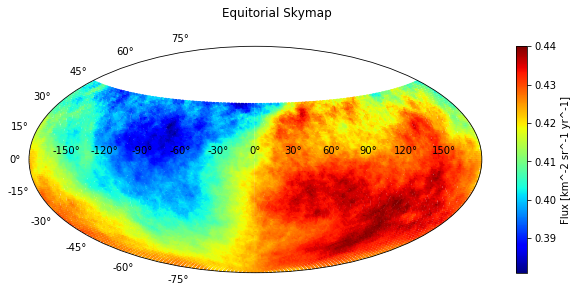

In [137]:
cm = plt.cm.get_cmap('jet')


fig = plt.figure()
plt.subplot(211, projection="aitoff")

sc = plt.scatter(wrap_around_180(auger_flux_data[:,1]), np.deg2rad(auger_flux_data[:,0]),
                 cmap=cm, c=auger_flux_data[:,2], vmin=min(auger_flux_data[:,2]),
                 vmax=max(auger_flux_data[:,2]), s=2)

cbar = plt.colorbar(sc)
cbar.set_label(r'Flux [km^-2 sr^-1 yr^-1]')

plt.suptitle("Equitorial Skymap")
plt.tight_layout()
fig.set_size_inches(10, 8)
plt.show()
    
# interactive(skymap, time=widgets.FloatSlider(min=2004., max=2016.5, step=0.5, value=2004.5))
